In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.linalg import norm, orthogonal_procrustes
from scipy.spatial import procrustes
from math import atan, sin, cos

#from WeatherTyping import loop_kmeans, get_number_eof, get_classifiability_index

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def procrustes2(data1, data2):
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)

    if mtx1.ndim != 2 or mtx2.ndim != 2:
        raise ValueError("Input matrices must be two-dimensional")
    if mtx1.shape != mtx2.shape:
        raise ValueError("Input matrices must be of same shape")
    if mtx1.size == 0:
        raise ValueError("Input matrices must be >0 rows and >0 cols")

    # translate all the data to the origin
    mtx1 -= np.mean(mtx1, 0)
    mtx2 -= np.mean(mtx2, 0)

    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)

    if norm1 == 0 or norm2 == 0:
        raise ValueError("Input matrices must contain >1 unique points")

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    mtx1 /= norm1
    mtx2 /= norm2

    # transform mtx2 to minimize disparity
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s    # HERE, the projected mtx2 is estimated.

    # measure the dissimilarity between the two datasets
    disparity = np.sum(np.square(mtx1 - mtx2))

    return mtx1, mtx2, disparity, R,s

In [3]:
def procrustes2d(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy. 
    -- Modified by Á.G. Muñoz (agmunoz@iri.columbia.edu)

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        X is the reference or target field, and Y is the field to be trans-
        formed. They must have equal numbers of  points (rows), but Y may 
        have fewer dimensions (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(axis=0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y
        
%      c:  the translation component
%      T:  the orthogonal rotation and reflection component
%      b:  the scale component
%   That is, Z = TRANSFORM.b * Y * TRANSFORM.T + TRANSFORM.c.

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(axis=0)
    muY = Y.mean(axis=0)

    X0 = X - np.broadcast_to(muX,(n,m))
    Y0 = Y - np.broadcast_to(muY,(ny,my))

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    Tmat = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(Tmat) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            Tmat = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = np.dot(normX,np.dot(traceTA,np.matmul(Y0, Tmat))) + np.broadcast_to(muX,(n,m))  

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = np.dot(normY,np.matmul(Y0, Tmat)) + np.broadcast_to(muX,(n,m))

    # transformation matrix
    if my < m:
        Tmat = Tmat[:my,:]
    c = muX - np.dot(b,np.matmul(muY, Tmat)) 

    #transformation values 
    tform = {'rotation':Tmat, 'scale':b, 'translation':np.broadcast_to(c,(n,m))}

    return d, Z, tform

# Read Data

#### Specify OpenDAP link to IRIDL location of the reanalysis WTs

In [4]:
urlr = 'http://iridl.ldeo.columbia.edu/home/.xchourio/.NOAA/.WTs/.Obs/.SingleDay/.MERRA/.WT/Y/%2819%29/%2881%29/RANGE/X/%28-141%29/%28-49%29/RANGE/dods'
WTrea = np.squeeze(xr.open_dataset(urlr,decode_times=False))

print (WTrea)

<xarray.Dataset>
Dimensions:  (X: 39, Y: 27, wt: 7)
Coordinates:
  * wt       (wt) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
    T        float32 2.5
  * Y        (Y) float32 17.5 20.0 22.5 25.0 27.5 ... 72.5 75.0 77.5 80.0 82.5
  * X        (X) float32 -142.5 -140.0 -137.5 -135.0 ... -55.0 -52.5 -50.0 -47.5
Data variables:
    WT       (wt, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL


#### Specify OpenDAP link to IRIDL location of the model WTs

In [5]:
urlm = 'http://iridl.ldeo.columbia.edu/home/.xchourio/.NOAA/.WTs/.amip/.SingleDay/.PRCP/.GFDL_CM3/.WT/Y/%2820%29/%2880%29/RANGE/X/%28-140%29/%28-50%29/RANGE/dods'
WTmod = np.squeeze(xr.open_dataset(urlm,decode_times=False))

print (WTmod)

<xarray.Dataset>
Dimensions:  (X: 38, Y: 32, wt: 7)
Coordinates:
  * wt       (wt) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
    T        float32 2.5
  * Y        (Y) float32 19.0 21.0 23.0 25.0 27.0 ... 73.0 75.0 77.0 79.0 81.0
  * X        (X) float32 -141.25 -138.75 -136.25 ... -53.75 -51.25 -48.75
Data variables:
    WT       (wt, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL


#### Spatial interpolation

In [6]:
#Here we interpolate the model reanalysis WT grid to the model one, to have a fair comparison
WTrea=WTrea.interp_like(WTmod)
WTrea

<xarray.Dataset>
Dimensions:  (X: 38, Y: 32, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float64 19.0 21.0 23.0 25.0 27.0 ... 73.0 75.0 77.0 79.0 81.0
  * X        (X) float64 -141.2 -138.8 -136.2 -133.8 ... -53.75 -51.25 -48.75
Data variables:
    WT       (wt, Y, X) float64 17.05 16.95 16.54 16.1 ... -100.1 -100.2 -100.4
Attributes:
    Conventions:  IRIDL

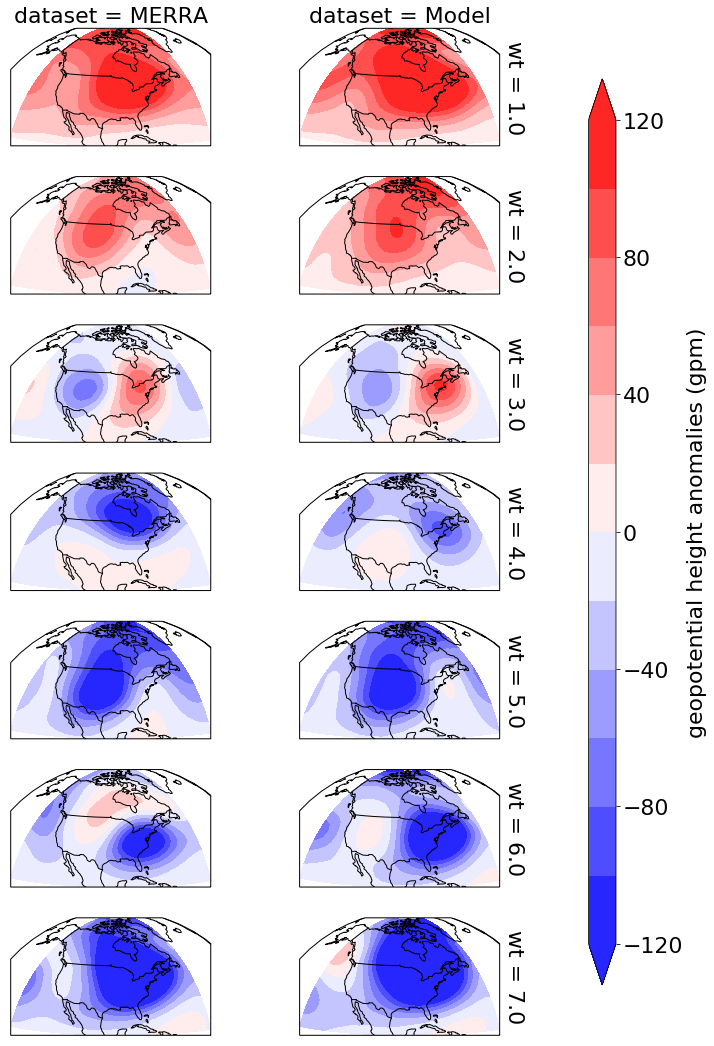

In [18]:
WT=xr.concat([WTrea, WTmod], pd.Index(['MERRA', 'Model'], name='dataset'))
ecu=WTmod

plt.rcParams.update({'font.size': 22})

p = WT.WT.plot.contourf(
    x='X', y='Y', row='wt', col='dataset',
    transform=ccrs.PlateCarree(),
    subplot_kws={
        'projection': ccrs.Orthographic(-90, 10)
        #ccrs.PlateCarree()
    },
    figsize=(13, 15),
    levels = np.arange(-120, 130, 20),
    cmap=plt.cm.bwr,
    extend='both',
    cbar_kwargs=dict(label='geopotential height anomalies (gpm)',pad=0.1, aspect=30, shrink=0.9) #, orientation='horizontal', ticks=[0, 10, 20 ,30])
)

xmin,xmax = WTmod.WT['X'].min(), WTmod.WT['X'].max()
ymin,ymax = WTmod.WT['Y'].min(), WTmod.WT['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([xmin, xmax, ymin, ymax])

plt.show()

# Procrustes Analysis

In [8]:
print("Disparity (0 means perfect match) for:")
for iwt in range(len(WTrea['wt'])):
    mtx1, mtx2, disparity,R,s = procrustes2(WTrea.WT[iwt], WTmod.WT[iwt])
    print("WT "+str(int(iwt+1))+ ":" +str(round(disparity,2)))

Disparity (0 means perfect match) for:
WT 1:0.06
WT 2:0.12
WT 3:0.06
WT 4:0.24
WT 5:0.04
WT 6:0.4
WT 7:0.11


In [9]:
WTmodT=xr.full_like(WTmod,0)
print("Disparity (0 means perfect match) for:")
for iwt in range(len(WTrea['wt'])):
    d,z,t = procrustes2d(WTrea.WT[iwt], WTmod.WT[iwt],scaling=True, reflection='best')
    WTmodT.WT[iwt]=z 
    print("WT "+str(int(iwt+1))+ ":" +str(round(d,2)))

Disparity (0 means perfect match) for:
WT 1:0.06
WT 2:0.12
WT 3:0.06
WT 4:0.24
WT 5:0.04
WT 6:0.4
WT 7:0.11


In [10]:
np.round(t['scale'],2).values

array(0.84)

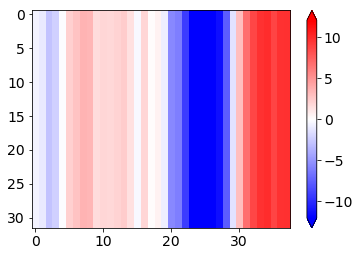

In [11]:
plt.rcParams.update({'font.size': 14})
p=plt.imshow(np.round(t['translation'],2),cmap=plt.cm.bwr,vmin=-12,vmax=12)
plt.colorbar(p, extend='both')

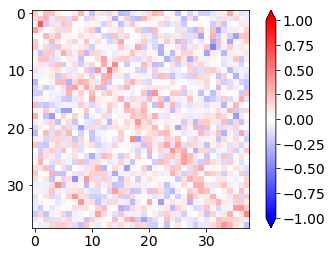

In [12]:
p=plt.imshow(np.round(t['rotation'],2),cmap=plt.cm.bwr,vmin=-1,vmax=1)
plt.colorbar(p, extend='both')

In [13]:
WTf=xr.concat([WTrea, WTmod, WTmodT], pd.Index(['MERRA', 'GFDLCM3', 'GFDLCM3 (Proc)'], name='dataset'))

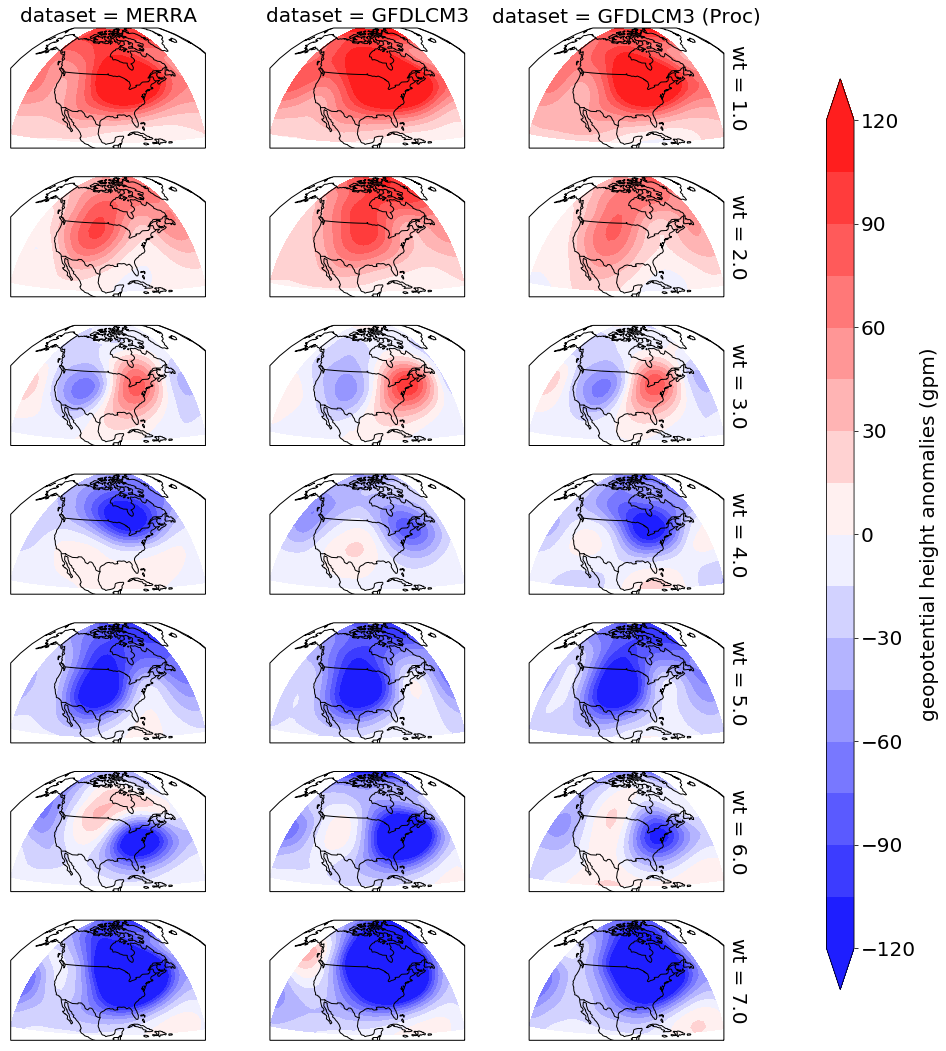

In [19]:
plt.rcParams.update({'font.size': 20})

p = WTf.WT.plot.contourf(
    x='X', y='Y', row='wt', col='dataset',
    transform=ccrs.PlateCarree(),aspect=WTf.dims['X'] / WTf.dims['Y'],
    subplot_kws={
        'projection': ccrs.Orthographic(-90, 10)  #ccrs.Orthographic(-80, 35)
        #ccrs.PlateCarree()
    },
    figsize=(15, 15),
    levels = np.arange(-120, 130, 15),
    cmap=plt.cm.bwr,
    extend='both',
    cbar_kwargs=dict(label='geopotential height anomalies (gpm)',pad=0.1, aspect=30, shrink=0.9) #, orientation='horizontal', ticks=[0, 10, 20 ,30])
)
#for i, ax in enumerate(p.axes.flat):
#    ax.set_title(WTf.dataset[i].values)
    
xmin,xmax = WTmod.WT['X'].min(), WTmod.WT['X'].max()
ymin,ymax = WTmod.WT['Y'].min(), WTmod.WT['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([xmin, xmax, ymin, ymax])
    #ax.set_title(WTf.dataset[i].values)

plt.show()

In [15]:
WTf

<xarray.Dataset>
Dimensions:  (X: 38, Y: 32, dataset: 3, wt: 7)
Coordinates:
    T        float32 2.5
  * X        (X) float64 -141.2 -138.8 -136.2 -133.8 ... -53.75 -51.25 -48.75
  * Y        (Y) float64 19.0 21.0 23.0 25.0 27.0 ... 73.0 75.0 77.0 79.0 81.0
  * wt       (wt) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * dataset  (dataset) object 'MERRA' 'GFDLCM3' 'GFDLCM3 (Proc)'
Data variables:
    WT       (dataset, wt, Y, X) float64 17.05 16.95 16.54 ... -78.61 -80.2
Attributes:
    Conventions:  IRIDL